###Define Module

In [ ]:
import platform
print("python " + platform.python_version())

python 3.7.13


In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y -c rdkit rdkit python=3.7
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-08-10 16:45:03--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2022-08-10 16:45:03--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76607678 (73M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  73.06M  99.1MB/s    in 0.7s    

2022-08-10 16:45:04 (99.1 MB/s) - ‘Miniconda3-latest-Linu

In [ ]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem
# from rdkit import Chem

print(Chem.__doc__)

 A module for molecules and stuff

 see Chem/index.html in the doc tree for documentation




In [ ]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Crippen
from rdkit.Chem import QED

from IPython.display import SVG
print('rdkit version: ', rdBase.rdkitVersion)
# rdkit version:  2020.03.1

rdkit version:  2020.09.1


In [ ]:
def verify_smiles(smile):
    return (smile != '') and pd.notnull(smile) and (Chem.MolFromSmiles(smile) is not None)

def good_smiles(smile):
    if verify_smiles(smile):
        return canon_smiles(smile)
    else:
        return None

def canon_smiles(smi):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smi), isomericSmiles=True, canonical=True)

In [ ]:
!git clone -l -s https://github.com/rdkit/rdkit.git
%cd /content/rdkit/Contrib/SA_Score

import sascorer

%cd /content

Cloning into 'rdkit'...
remote: Enumerating objects: 79570, done.
remote: Counting objects: 100% (559/559), done.
remote: Compressing objects: 100% (361/361), done.
remote: Total 79570 (delta 323), reused 373 (delta 192), pack-reused 79011
Receiving objects: 100% (79570/79570), 190.34 MiB | 31.42 MiB/s, done.
Resolving deltas: 100% (60975/60975), done.
/content/rdkit/Contrib/SA_Score
/content


###Load molecular data

In [ ]:
import pandas as pd
url = 'https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv'
df1 = pd.read_csv(url)
smiles = df1["smiles"].values

logP = df1["logP"].values
qed = df1["qed"].values
SAS = df1["SAS"].values

chars = set()

for smi in smiles:
    chars = chars.union(set(char for char in smi))
chars = sorted(list(chars))

char_dict = dict((char, i) for i,char in enumerate(chars))

num_dict = dict((i,char) for i,char in enumerate(chars))

chars_size=len(char_dict)
max_length = max(len(s) for s in smiles)

In [ ]:
num_dict[0] = '<EOS>'

In [ ]:
def draw_smiles(smiles):
    Draw.MolToFile(Chem.MolFromSmiles(smiles),'test.png',size=(300, 300))
    return Draw.MolToImage(Chem.MolFromSmiles(smiles))

In [ ]:
X = np.zeros((len(smiles), 121), dtype=np.int64)

for n, smi in enumerate(smiles):
    for m, char in enumerate(smi):
        char_idx = char_dict[char]
        X[n, m] = char_idx

In [ ]:
def Onehot2smiles_input(sample): #Input data must have shape (n ,120, 36) 
  truth_list =[]
  for sam in sample:
    sample_onehot = sam.reshape(1,120,35)
    sample_truth = []
    for idx in range(max_length):
        sam = sam.reshape(1,120,35)
        char_idx = np.where(sample_onehot[0,idx,:]==1)[0]
        if not list(char_idx):
            break
        char_idx = char_idx[0]
        char = num_dict[char_idx]
        sample_truth.append(char)

    truth = "".join(sample_truth)
    truth_list.append(truth)
    #print(truth)
  
  return truth_list

def Onehot2smiles_output(sample_onehot_pred):
  pred_list =[]   
  for sam in sample_onehot_pred:
    sample_pred = []
    for idx in range(max_length):
       sam = sam.reshape(1,120,35)
       char_idx = np.where(sam[0,idx,:]==max(sam[0,idx,:]))[0]
       #if not list(char_idx):
       #   break
       char_idx = char_idx[0]
       char = num_dict[char_idx]
       sample_pred.append(char)
      
    pred = "".join(sample_pred)
    pred_list.append(pred)
   
  return pred_list

def decode_smiles_from_indexes(vec):
    smiles = "".join(map(lambda x: num_dict[x], vec)).strip()
    return smiles.split('<EOS>')[0]

In [ ]:
Y = np.zeros((len(smiles), 3), dtype=np.float32)

for i in range(len(smiles)):
  Y[i, 0] = logP[i]
  Y[i, 1] = qed[i]
  Y[i, 2] = SAS[i]

In [ ]:
(x_train), (x_test) = X[:], X[-10000:] #　!!確認!!
(y_train), (y_test) = Y[:], Y[-10000:]

x_train = np.asarray(x_train)
x_train = x_train.astype('int64')
x_train = np.reshape(x_train, (len(x_train), 1, 121))
print(x_train.shape)

x_test = np.asarray(x_test)
x_test = x_test.astype('int64')
x_test = np.reshape(x_test, (len(x_test), 1, 121))
print(x_test.shape)

y_train = np.asarray(y_train)
y_train = y_train.astype('float32')
y_train = np.reshape(y_train, (len(y_train), 3))
print(y_train.shape)

y_test = np.asarray(y_test)
y_test = y_test.astype('float32')
y_test = np.reshape(y_test, (len(y_test), 3))
print(y_test.shape)

(249455, 1, 121)
(10000, 1, 121)
(249455, 3)
(10000, 3)


In [ ]:
import torch
from torch.utils.data import  Dataset

x_train = torch.from_numpy(x_train).clone()
x_test = torch.from_numpy(x_test).clone()

y_train = torch.from_numpy(y_train).clone()
y_test = torch.from_numpy(y_test).clone()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
valid_dataset = test_dataset

### For PixelCNN

In [ ]:
#module
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)

class GatedActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x, y = x.chunk(2, dim=1)#二つに分割
        return F.tanh(x) * F.sigmoid(y)


class GatedMaskedConv2d(nn.Module):
    def __init__(self, mask_type, dim, kernel, residual=True, cond_dimension=1):
        super().__init__()
        assert kernel % 2 == 1, print("Kernel size must be odd")
        self.mask_type = mask_type
        self.residual = residual
        self.dim = dim

        self.class_cond_embedding = nn.Linear(in_features=cond_dimension, out_features=2 * dim)

        kernel_shp = (kernel // 2 + 1, kernel)  # (ceil(n/2), n)
        padding_shp = (kernel // 2, kernel // 2)
        self.vert_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.vert_to_horiz = nn.Conv2d(2 * dim, 2 * dim, 1)

        kernel_shp = (1, kernel // 2 + 1)
        padding_shp = (0, kernel // 2)
        self.horiz_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.horiz_resid = nn.Conv2d(dim, dim, 1)

        self.gate = GatedActivation()

    def make_causal(self):
        self.vert_stack.weight.data[:, :, -1].zero_()  # Mask final row
        self.horiz_stack.weight.data[:, :, :, -1].zero_()  # Mask final column

    def forward(self, x_v, x_h, h):
        if self.mask_type == 'A':
            self.make_causal()
            
        h = self.class_cond_embedding(h)
        h_vert = self.vert_stack(x_v)
        h_vert = h_vert[:, :, :x_v.size(-1), :] #形を整える
        out_v = self.gate(h_vert + h[:, :, None, None])

        h_horiz = self.horiz_stack(x_h)
        h_horiz = h_horiz[:, :, :, :x_h.size(-2)]
        v2h = self.vert_to_horiz(h_vert)

        out = self.gate(v2h + h_horiz + h[:, :, None, None])
        if self.residual:
            out_h = self.horiz_resid(out) + x_h
        else:
            out_h = self.horiz_resid(out)

        return out_v, out_h


class GatedPixelCNN(nn.Module):
    def __init__(self, input_dim=256, dim=64, n_layers=15, cond_dimension=1):
        super().__init__()
        self.dim = dim

        # Create embedding layer to embed input
        self.embedding = nn.Embedding(input_dim, dim)

        # Building the PixelCNN layer by layer
        self.layers = nn.ModuleList()

        # Initial block with Mask-A convolution
        # Rest with Mask-B convolutions
        for i in range(n_layers):
            mask_type = 'A' if i == 0 else 'B'
            kernel = 7 if i == 0 else 3
            residual = False if i == 0 else True

            self.layers.append(
                GatedMaskedConv2d(mask_type, dim, kernel, residual, cond_dimension)
            )

        # Add the output layer
        self.output_conv = nn.Sequential(
            nn.Conv2d(dim, 512, 1),
            nn.ReLU(True),
            nn.Conv2d(512, input_dim, 1)
        )

        self.apply(weights_init)

    def forward(self, x, label):
        shp = x.size() + (-1, )
        x = self.embedding(x.view(-1)).view(shp)  # (B, H, W, C)
        x = x.permute(0, 3, 1, 2)  # (B, C, W, W)

        x_v, x_h = (x, x)
        for i, layer in enumerate(self.layers):
            x_v, x_h = layer(x_v, x_h, label)

        return self.output_conv(x_h)

    def generate(self, label, bias=0, shape=(11, 11), batch_size=64, start=None, st_len=None):
        param = next(self.parameters())
        x = torch.zeros((batch_size, *shape), dtype=torch.int64, device=param.device)
        prob_list = np.zeros((batch_size, 35, *shape))
        
        if bias==0:
          for i in range(shape[0]):
              for j in range(shape[1]):
                  logits = self.forward(x, label)
                  probs = F.softmax(logits[:, :, i, j], -1)
                  prob_list[:, :, i, j] = probs[:, :].cpu().detach().numpy()
                  #Ramdom sampling
                  x.data[:, i, j].copy_(
                     probs.multinomial(1).squeeze().data
                  )
        
        # Insert starting molecular -> Input x
        if bias=="benzene":
          for i in range(batch_size):
            # start:starting molecule
            x[i,:,:] = start.view(11, 11)[:,:]
            
            i_min = st_len//11 - 1
            j_min = st_len%11 - 1

          for i in range(shape[0]):
            if i>i_min:
              for j in range(shape[1]):
                if j>j_min:
                  logits = self.forward(x, label)
                  probs = F.softmax(logits[:, :, i, j], -1)
                  prob_list[:, :, i, j] = probs[:, :].cpu().detach().numpy()
                  x.data[:, i, j].copy_(probs.multinomial(1).squeeze().data)

        return x, prob_list

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import json

from torchvision import transforms, datasets

from tensorboardX import SummaryWriter


def train(data_loader, prior, optimizer, args, writer):
    for images, labels in data_loader:
        with torch.no_grad():
            images = images.to(args.device)
            images = images.detach()
            images = images.view(-1, 11, 11)

        labels = labels.to(args.device)
        logits = prior(images, labels)
        logits = logits.permute(0, 2, 3, 1).contiguous()

        optimizer.zero_grad()
        loss = F.cross_entropy(logits.view(-1, args.k),
                               images.view(-1))
        loss.backward()

        # Logs
        writer.add_scalar('loss/train', loss.item(), args.steps)

        optimizer.step()
        args.steps += 1

def test(data_loader, prior, args, writer):
    with torch.no_grad():
        loss = 0.
        for images, labels in data_loader:
            images = images.to(args.device)
            labels = labels.to(args.device)

            images = images.detach()
            images = images.view(-1, 11, 11)

            logits = prior(images, labels)
            logits = logits.permute(0, 2, 3, 1).contiguous()
            loss += F.cross_entropy(logits.view(-1, args.k),
                                    images.view(-1))

        loss /= len(data_loader)

    # Logs
    writer.add_scalar('loss/valid', loss.item(), args.steps)

    return loss.item()

def decoding_rate(prior, args, writer, batch_size=10):
    counter = 0
    labels = y_train[:batch_size].to(args.device)
    for i in range(10):
      feature, _ = prior.generate(labels, batch_size=batch_size)
      feature = feature.view(-1, 121)
      for i, vec in enumerate(feature):
        smi = decode_smiles_from_indexes(vec.cpu().detach().numpy())
        if verify_smiles(smi) == True:
          mol = Chem.MolFromSmiles(smi)
          logp = Crippen.MolLogP(mol)
          qed = QED.weights_mean(mol)
          SAS = sascorer.calculateScore(mol)

          print(smi)
          print("True LogP:"+str(logp) +"   Predicted LogP:" + str(y_train[i, 0].cpu().detach().numpy()))
          print("True qed:"+str(qed) +"   Predicted qed:" + str(y_train[i, 1].cpu().detach().numpy()))
          print("True SAS:"+str(SAS) +"   Predicted qed:" + str(y_train[i, 2].cpu().detach().numpy()))

          counter +=1

    accuracy = counter
    writer.add_scalar('accuracy/train', accuracy/1., args.steps)

def main_prior(args, Restart = False):
    writer = SummaryWriter('./logs/{0}'.format(args.output_folder))
    save_filename = './models/{0}/prior.pt'.format(args.output_folder)

    # Define the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.num_workers, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
        batch_size=args.batch_size, shuffle=False, drop_last=True,
        num_workers=args.num_workers, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset,
        batch_size=16, shuffle=True)
    

    prior = GatedPixelCNN(args.k, args.hidden_size_prior, args.num_layers, cond_dimension=3).to(args.device)

    if Restart:
        with open('/content/models/prior/prior_40.pt', 'rb') as f:
            state_dict = torch.load(f)
            prior.load_state_dict(state_dict)
            decoding_rate(prior, args, writer)

    optimizer = torch.optim.Adam(prior.parameters(), lr=args.lr)

    best_loss = -1.
    for epoch in range(args.num_epochs):
        train(train_loader, prior, optimizer, args, writer)
        # The validation loss is not properly computed since
        # the classes in the train and valid splits of Mini-Imagenet
        # do not overlap.
        loss = test(valid_loader, prior, args, writer)
        
        if epoch%1==0:
          decoding_rate(prior, args, writer)

        if (epoch == 0) or (loss < best_loss):
            best_loss = loss
            with open(save_filename, 'wb') as f:
                torch.save(prior.state_dict(), f)
        with open('./models/prior/prior_{0}.pt'.format(epoch + 1), 'wb') as f:
            torch.save(prior.state_dict(), f)

### for Training PixelCNN

In [ ]:
import argparse
import os
import multiprocessing as mp

class args(): 
    def __init__(self):
        self.data_folder = './' 
        self.hidden_size_prior = 64
        self.k = 35
        self.num_layers = 15 
        self.batch_size = 128
        self.num_epochs = 500
        self.lr = 3e-4
        self.output_folder = 'prior'
        self.num_workers = 0
        self.device = 'cuda'
args = args()

In [ ]:
#Train Pixel CNN
# Create logs and models folder if they don't exist
if not os.path.exists('./logs'):
     os.makedirs('./logs')
if not os.path.exists('./models'):
    os.makedirs('./models')
# Device
args.device = torch.device(args.device
    if torch.cuda.is_available() else 'cpu')
# Slurm
if 'SLURM_JOB_ID' in os.environ:
    args.output_folder += '-{0}'.format(os.environ['SLURM_JOB_ID'])
if not os.path.exists('./models/{0}'.format(args.output_folder)):
    os.makedirs('./models/{0}'.format(args.output_folder))
args.steps = 0

main_prior(args)
#main_prior(args, Restart = True)

### Molecular generation

In [ ]:
import matplotlib.pyplot as plt
import math

batch_size = 100
counter = 0
average_logp = 0.0
average_qed = 0.0
average_SAS = 0.0

smiles_list = []
logP_list = []
qed_list = []
SAS_list = []

True_logP_list = []
True_qed_list = []
True_SAS_list = []

Moleculars = []

#__________________________________________

num_trial = 500
#target_index = 2
al = 1.0 # *
be = 0.0 # +
ga = 0.0 # +

#__________________________________________

for i, iter in enumerate(range(num_trial)):

  arr = np.random.randint(0, len(x_train), (batch_size*num_trial,))

  smile = x_train[arr[batch_size*i : batch_size*(i+1)]].cpu().detach().numpy()
  labels = y_train[arr[batch_size*i : batch_size*(i+1)]].view(-1, 3)

  labels[:,0] = labels[:,0]*al
  labels[:,1] = labels[:,1]+be
  labels[:,2] = labels[:,2]+ga

  labels = labels.to('cuda')

  #__________________________________________
  
  feature , _ = prior.generate(labels, batch_size=batch_size)

  feature = feature.view(-1, 121)
  
  for i, vec in enumerate(feature):
    
    smi = decode_smiles_from_indexes(vec.cpu().detach().numpy())
    ver = verify_smiles(smi)
    if ver == True:
      if verify_smiles(canon_smiles(smi)) == True:
        draw_smiles(smi)
        smiles_list.append(smi)

        print(smi)
        counter+=1

        mol = Chem.MolFromSmiles(smi)
        logp = Crippen.MolLogP(mol)
        qed = QED.weights_mean(mol)
        SAS = sascorer.calculateScore(mol)

        logP_list.append(logp)
        True_logP_list.append(labels[i,0].cpu().detach().numpy())

        qed_list.append(qed)
        True_qed_list.append(labels[i,1].cpu().detach().numpy())

        SAS_list.append(SAS)
        True_SAS_list.append(labels[i,2].cpu().detach().numpy())

        Moleculars.append(smi)

        average_logp += logp
        average_qed += qed
        average_SAS += SAS

        if int(counter)==1000:
          print("The number of molecules reaches 1000!")
          break
  
  else:
      continue
  break

print("Decoding rate : " + str(counter/num_trial))

average_logp/=counter
average_qed/=counter
average_SAS/=counter

counter/=num_trial

print("Average logP : "+ str(average_logp))
print("Average qed : "+ str(average_qed))
print("Average SAS : "+ str(average_SAS))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


CN(C)S(=O)(=O)c1ccccc1CNS(=O)(=O)c1cccnc1
C#CCCC[C@H](C)NC(=O)[C@H]1CC[NH+](Cc2ccc(CC)cc2)C1
CC(C)(C)OC(=O)N1CC[C@H](C(=O)NCc2n[nH]nc2C(C)C)C1
C[C@H](O[C@@H](C)c1cccnc1)[S@](C)(C)CCO
C[C@H]1CCCC[C@@H]1NC(=O)c1cc(S(N)(=O)=O)ccc1C
[NH3+][C@@H]1CC[C@@H](Oc2ccc(Cl)c(Cl)c2)C1
Cc1nc([C@@H]2CN3CCN(C(=O)COCC3)C2)sn1
CCn1c(=S)oc2cc(S(=O)(=O)N3CCOCC3)ccc21
CC(=O)NCCc1cccc(OCC(F)(F)F)c1F
Cc1ccc(OCC(=O)NCc2ccc(C(=O)NC)cc2)cc1
CC[NH2+][C@H](c1cccc(Cl)c1)c1ccccc1F
Cc1ccccc1CO[C@H](C)CNC(=O)c1cc[nH]c1
CC[C@H](C)CCNC(=O)N[C@H]1CCC[NH+](C2CC2)C1
Cn1cc([C@H]2CCCN2C(=O)c2cccc(Cn3cncc3)c2)nc1
CCOc1ccc(C(=O)N(C)C)cc1NC(=O)NCC1(c2ccc(F)cc2)CC1
COc1ccc(CNC(=O)NC[C@H](O)c2ccsc2)cc1
CCN(CC(=O)N1CCSCC1)c1ccc(F)cc1F
Cc1ccc(C)c(S(=O)(=O)NC(=O)CSc2cccn2Cc2ccc(Cl)cc2Cl)n1
COc1ccc(C[NH2+]Cc2ccsc2)c(C)c1
C#CC[C@@H](C)C(=O)OCC
O=[N+]([O-])c1cn(C[C@H]2C[C@H](c3cccs3)C2)c(O)c1
Cc1ccc(NC(=O)C(C)(C)C(=O)N(C)C)cc1S(=O)(=O)N(C)C
O=C([O-])[C@@H](O)c1ccc([N+](=O)[O-])cc1
CC[NH+](C[C@H]1CC[C@H](C)CC1)C(N)=O
Cc1ccc([C@@H]2C[C@H

### Plot prediction vs true properties

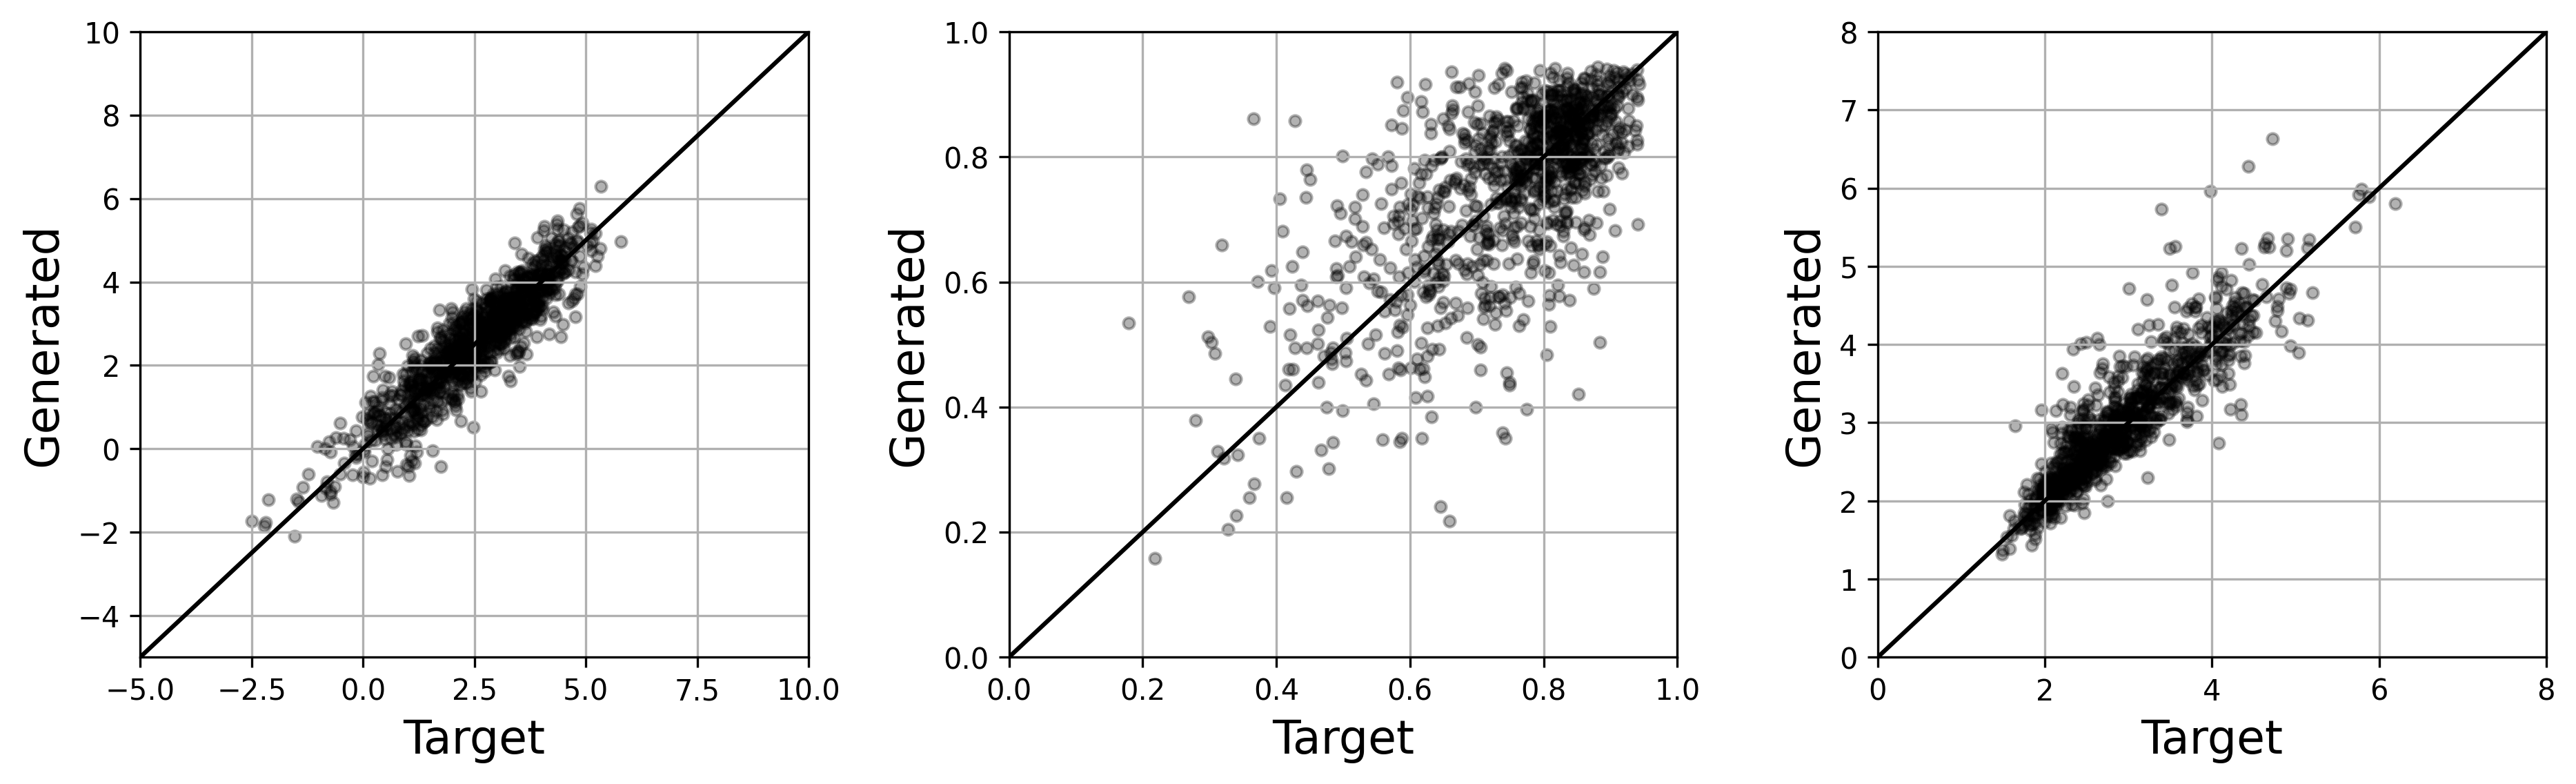

In [ ]:
fig=plt.figure(figsize=(15,4),dpi=300)
fig.subplots_adjust(hspace=0, wspace=0.3)

ax1=fig.add_subplot(131)
ax1.scatter(True_logP_list, logP_list, alpha=0.3, color="Black", linewidths="1", s=15)
#plt.title("LogP", fontsize = 16)
plt.xlabel("Target", fontsize = 16)
plt.ylabel("Generated", fontsize = 16)
plt.grid(True)
plt.xlim([-5,10])
plt.ylim([-5,10])

x = [-8,-3,0,2,4,7,10]
ax1.plot(x, x , color='black')

ax2=fig.add_subplot(132)
ax2.scatter(True_qed_list, qed_list, alpha=0.3, color="Black", linewidths="1", s=15)
#plt.title("QED", fontsize = 16)
plt.xlabel("Target", fontsize = 16)
plt.ylabel("Generated", fontsize = 16)
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])

x = [0,0.5,1.0]
ax2.plot(x, x , color='black')

ax3=fig.add_subplot(133)
ax3.scatter(True_SAS_list, SAS_list, alpha=0.3, color="Black", linewidths="1", s=15)
#plt.title("SAS", fontsize = 16)
plt.xlabel("Target", fontsize = 16)
plt.ylabel("Generated", fontsize = 16)
plt.grid(True)
plt.xlim([0,8])
plt.ylim([0,8])

x = [0,2,4,6,8]
ax3.plot(x, x , color='black')

plt.show()

In [ ]:
from sklearn.metrics import r2_score

R2 = r2_score(True_logP_list, logP_list)
print("R2 of LogP is {:3f}".format(R2))

R2 = r2_score(True_qed_list, qed_list)
print("R2 of QED is {:3f}".format(R2))

R2 = r2_score(True_SAS_list, SAS_list)
print("R2 of SAS is {:3f}".format(R2))

R2 of LogP is 0.817566
R2 of QED is 0.275135
R2 of SAS is 0.756727


### Visualization of generated moleculars' properties

In [ ]:
# To comvert temp vector into reserved vector
logP_higher=logP_list
qed_higher=qed_list
SAS_higher=SAS_list

In [ ]:
# Ramdom sample from training data
n_sample = 1000
arr = np.random.randint(0, len(x_train), (n_sample,))
labels = y_train[arr[:]].view(-1, 3).cpu().detach().numpy()

logP_train=labels[:, 0]
qed_train=labels[:, 1]
SAS_train=labels[:, 2]

#### Visualize histgram

2.44825405
2.304773070000001
3.384761040000002


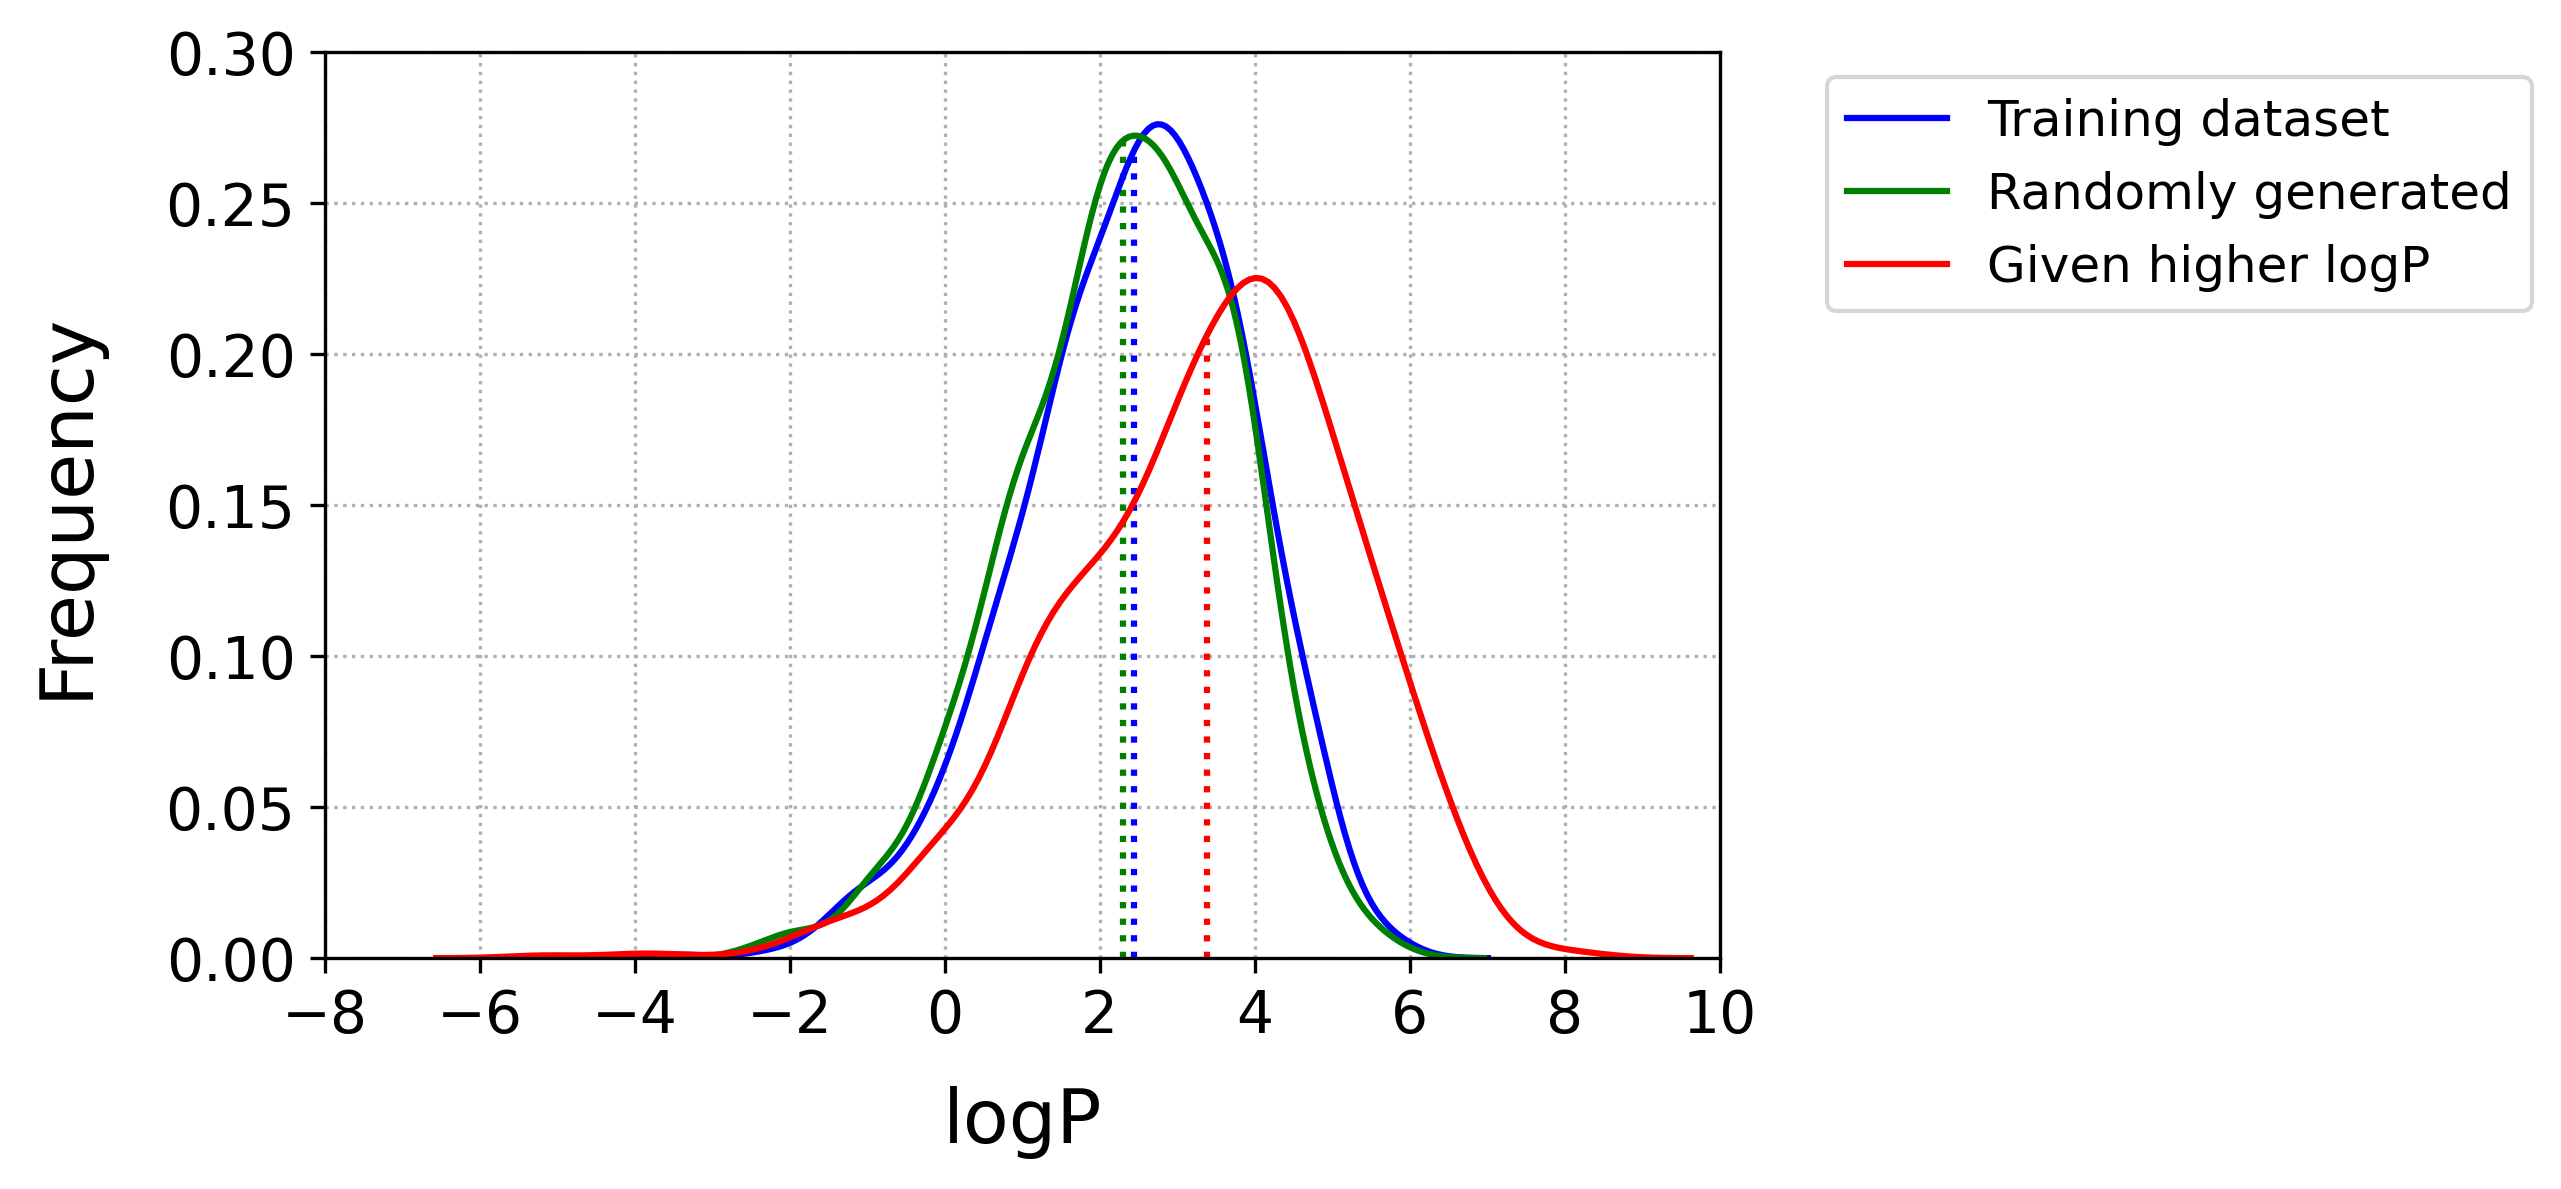

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1)

sns.kdeplot(logP_train, label="Training dataset", color="b")
sns.kdeplot(logP_free, label="Randomly generated", color="g")
sns.kdeplot(logP_higher, label="Given higher logP", color="r")

#ax.set_title("Histgram of LogP", fontsize=18)
ax.set_xlabel('logP', fontsize=18, labelpad=10)
ax.set_ylabel('Frequency', fontsize=18, labelpad=15)
ax.grid(linestyle='dotted')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-8., 10.0)
plt.ylim(0.00, 0.3)


ax.legend(bbox_to_anchor=(1.6, 1.0), fontsize=12)

# Visualization of mean value
kdeline = ax.lines[0]
mean3 = mean(logP_train)
print(mean3)
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height3 = np.interp(mean3, xs, ys)
ax.vlines(mean3, 0, height3, ls=':', color="b")

# Visualization of mean value
kdeline = ax.lines[1]
mean1 = mean(logP_free)
print(mean1)
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height1 = np.interp(mean1, xs, ys)
ax.vlines(mean1, 0, height1, ls=':', color="g")

# Visualization of mean value
kdeline = ax.lines[2]
mean2 = mean(logP_higher)
print(mean2)
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height2 = np.interp(mean2, xs, ys)
ax.vlines(mean2, 0, height2, ls=':', color="r")


fig.show()

0.72576760083
0.7475102271840829
0.7385718075945692


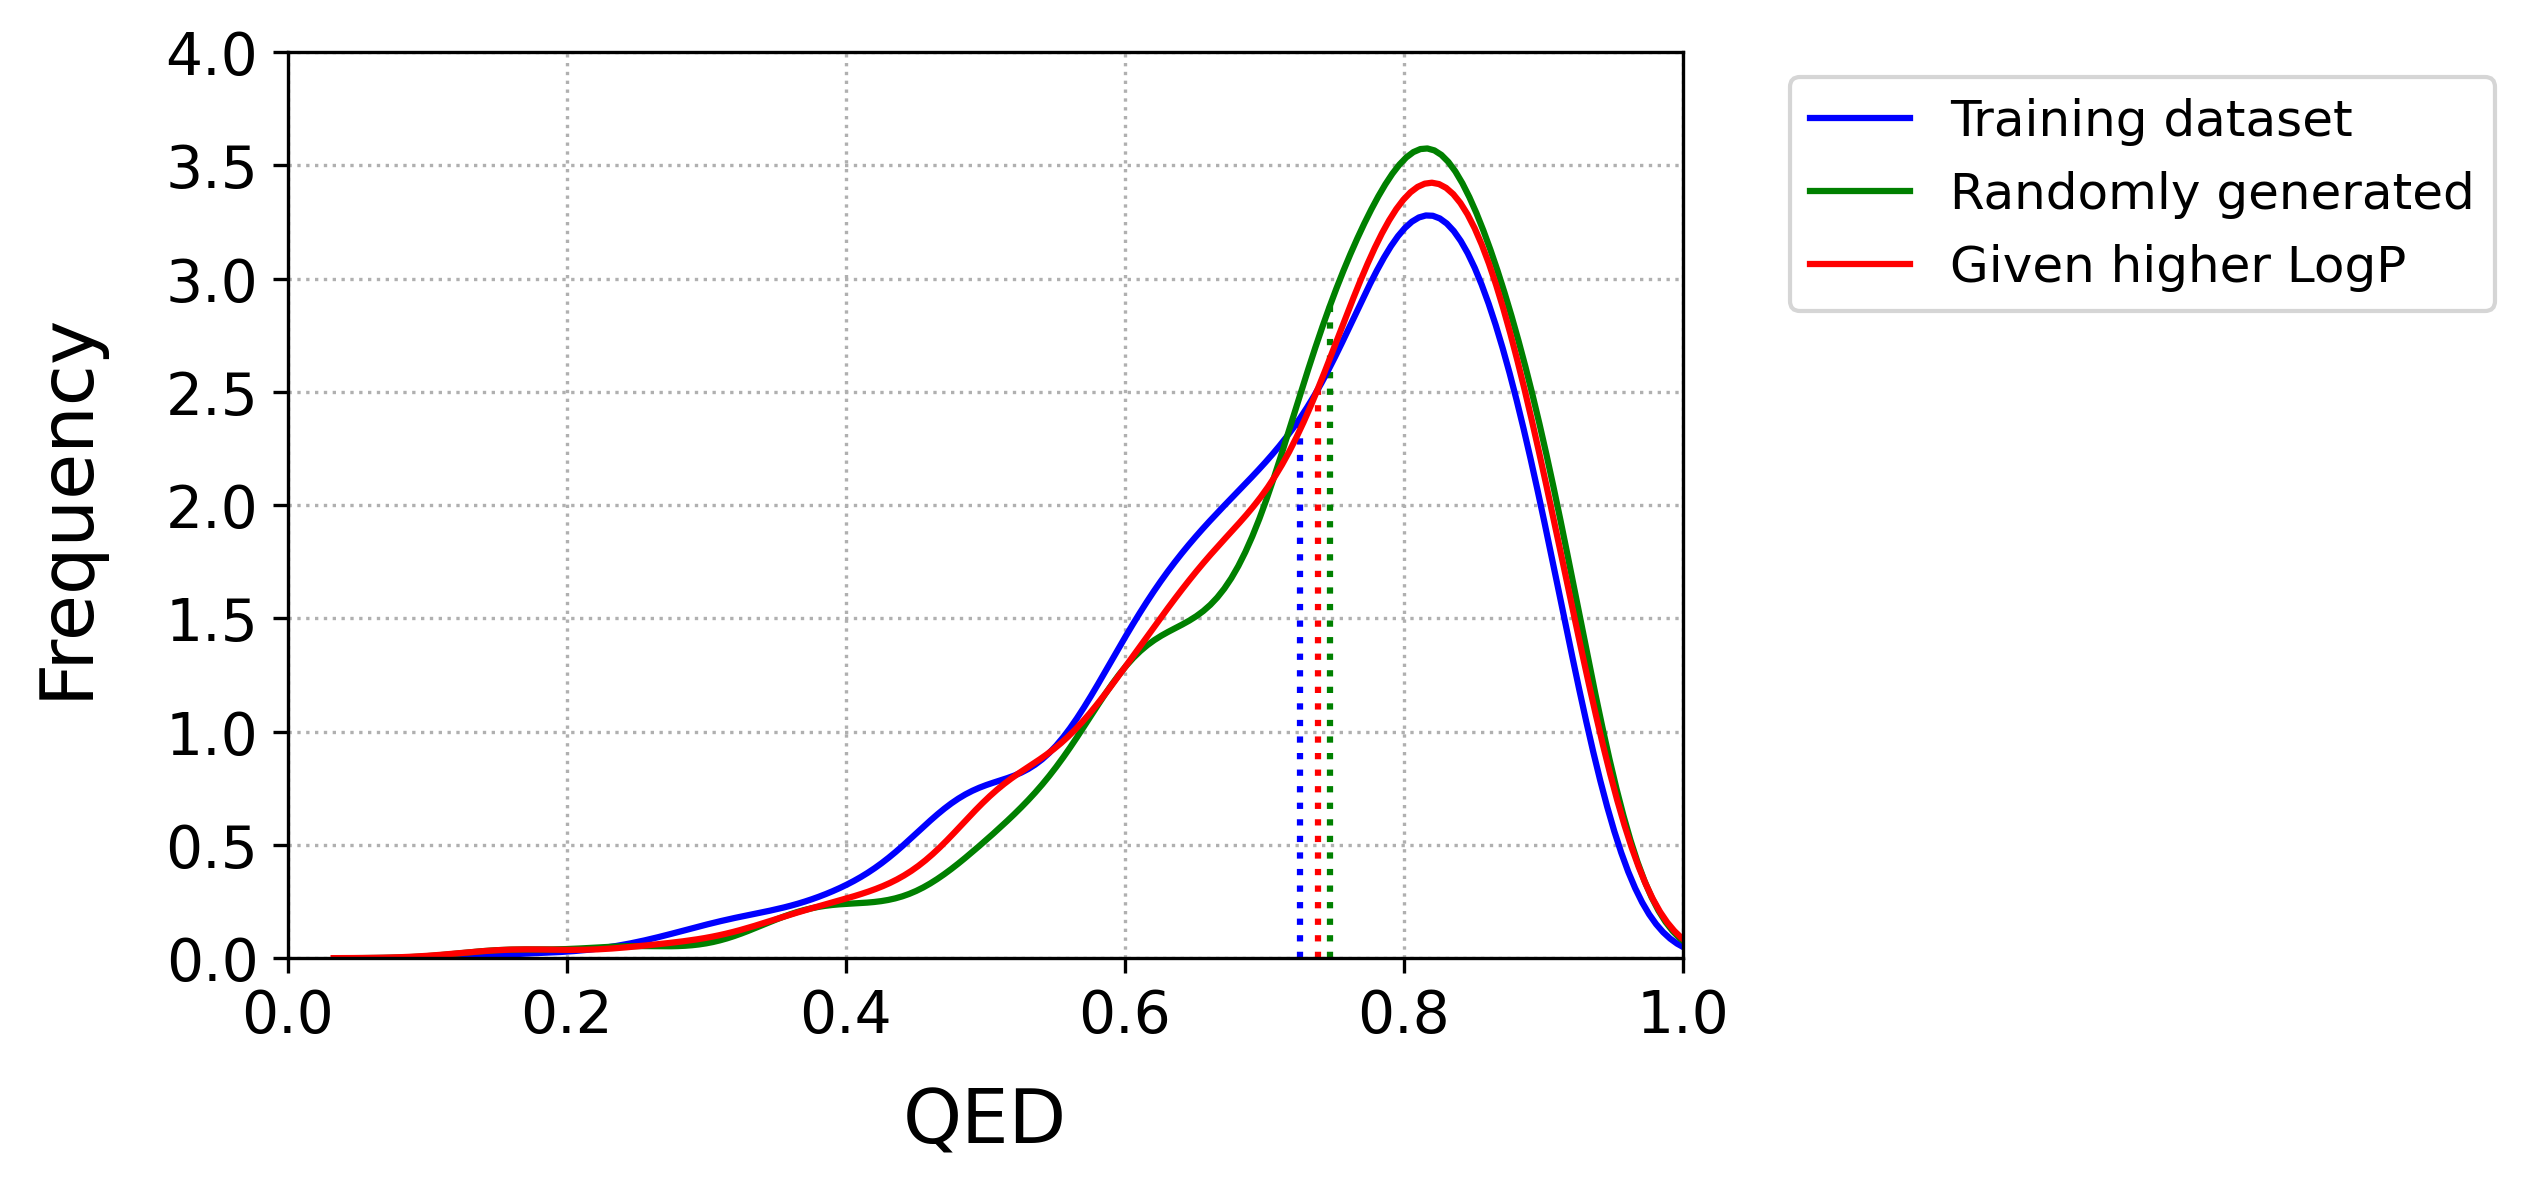

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1)

sns.kdeplot(qed_train, label="Training dataset", color="b")
sns.kdeplot(qed_free, label="Randomly generated", color="g")
sns.kdeplot(qed_higher, label="Given higher LogP", color="r")

#ax.set_title("Histgram of QED", fontsize=18)
ax.set_xlabel('QED', fontsize=18, labelpad=10)
ax.set_ylabel('Frequency', fontsize=18, labelpad=15)
ax.grid(linestyle='dotted')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 4.0)

ax.legend(bbox_to_anchor=(1.6, 1.), fontsize=12)

# Visualization of mean value
kdeline = ax.lines[0]
mean3 = mean(qed_train)
print(mean3)
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height3 = np.interp(mean3, xs, ys)
ax.vlines(mean3, 0, height3, ls=':', color="b")

# Visualization of mean value
kdeline = ax.lines[1]
mean1 = mean(qed_free)
print(mean1)
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height1 = np.interp(mean1, xs, ys)
ax.vlines(mean1, 0, height1, ls=':', color="g")

# Visualization of mean value
kdeline = ax.lines[2]
mean2 = mean(qed_higher)
print(mean2)
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height2 = np.interp(mean2, xs, ys)
ax.vlines(mean2, 0, height2, ls=':', color="r")

fig.show()

3.0810787367
3.1124225823693603
3.020463786859068


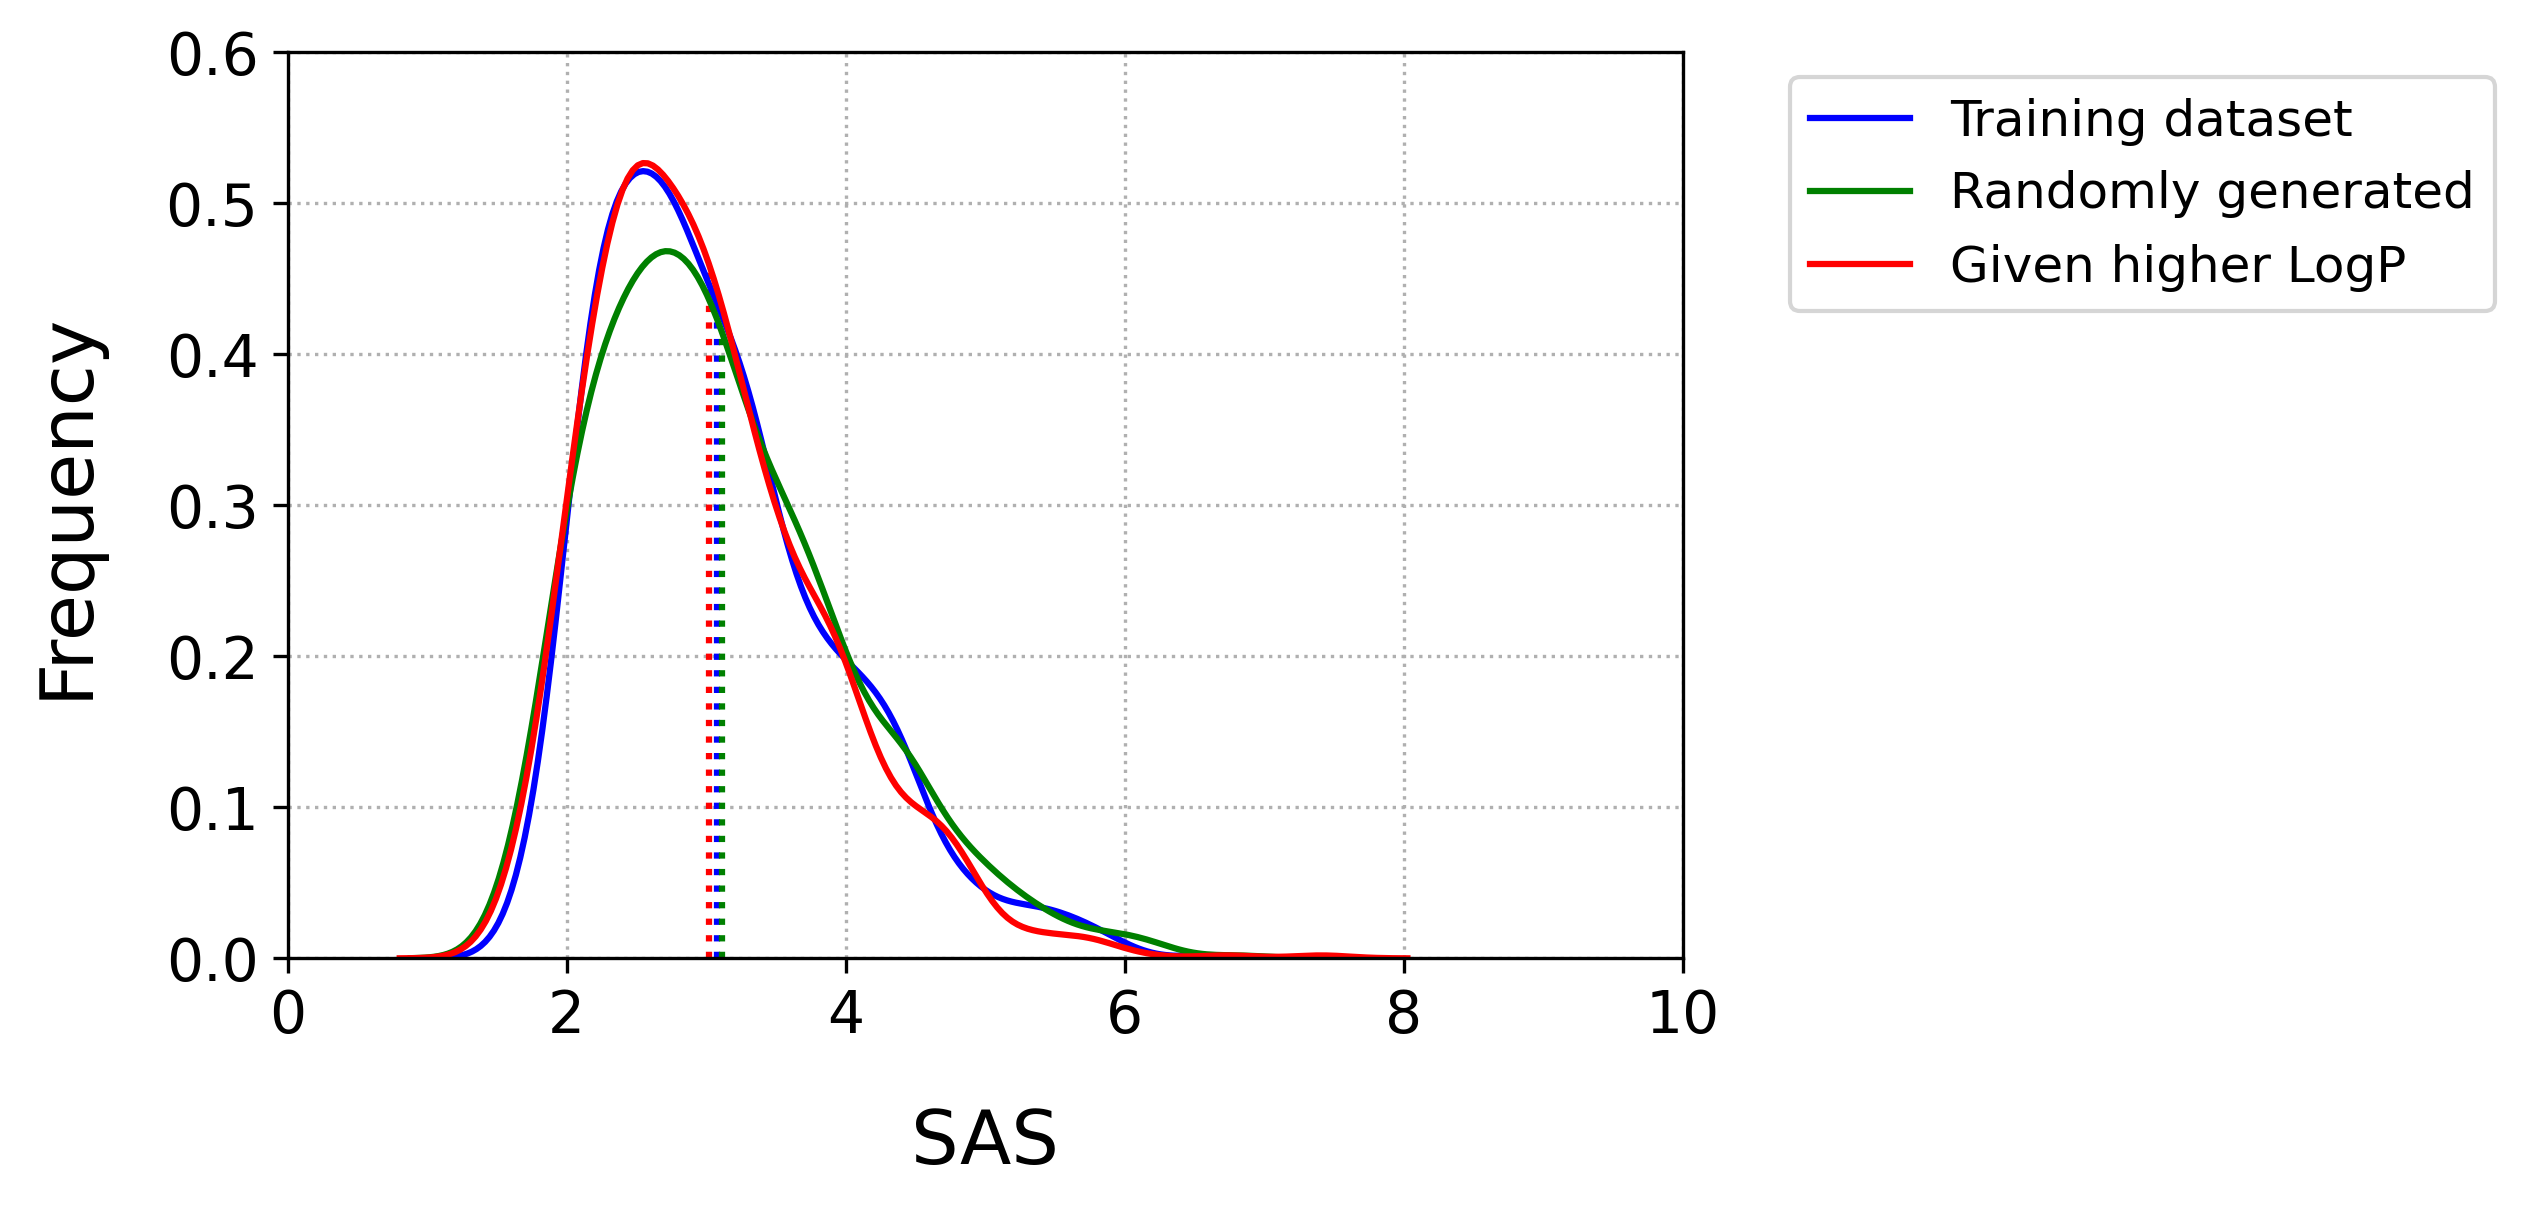

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1)

sns.kdeplot(SAS_train, label="Training dataset", color="b")
sns.kdeplot(SAS_free, label="Randomly generated", color="g")
sns.kdeplot(SAS_higher, label="Given higher LogP", color="r")

#ax.set_title("Histgram of SAS", fontsize=18)
ax.set_xlabel('SAS', fontsize=18, labelpad=15)
ax.set_ylabel('Frequency', fontsize=18, labelpad=15)
ax.grid(linestyle='dotted')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0.0, 10.0)
plt.ylim(0.0, 0.6)

ax.legend(bbox_to_anchor=(1.6, 1.), fontsize=12)

# Visualization of mean value
kdeline = ax.lines[0]
mean3 = mean(SAS_train)
print(mean3)
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height3 = np.interp(mean3, xs, ys)
ax.vlines(mean3, 0, height3, ls=':', color="b")

# Visualization of mean value
kdeline = ax.lines[1]
mean1 = mean(SAS_free)
print(mean1)
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height1 = np.interp(mean1, xs, ys)
ax.vlines(mean1, 0, height1, ls=':', color="g")

# Visualization of mean value
kdeline = ax.lines[2]
mean2 = mean(SAS_higher)
print(mean2)
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height2 = np.interp(mean2, xs, ys)
ax.vlines(mean2, 0, height2, ls=':', color="r")


fig.show()

### Serching molecular

In [ ]:
bz="c1ccccc1"

st_mol = np.zeros((121,), dtype=np.int64)
counter = 0

for i, char in enumerate(bz):
    char_idx = char_dict[char]
    st_mol[i] = char_idx
    counter+=1

st_mol = torch.from_numpy(st_mol).clone()

np.set_printoptions(threshold=1000)
print(st_mol)
print("smiles length is {}".format(counter))

st_len = counter

tensor([29,  7, 29, 29, 29, 29, 29,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
smiles length is 8


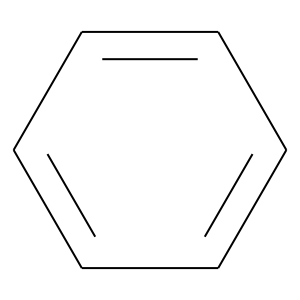

In [ ]:
draw_smiles(bz)

In [ ]:
mol = Chem.MolFromSmiles(bz)
logp = Crippen.MolLogP(mol)
qed = QED.weights_mean(mol)
SAS = sascorer.calculateScore(mol)

print("Benzene's LogP is {}".format(logp))
print("Benzene's QED is {}".format(qed))
print("Benzene's SAS is {}".format(SAS))

Benzene's LogP is 1.6866
Benzene's QED is 0.4426283718993647
Benzene's SAS is 1.0


In [ ]:
# Making labels

logp_target = logp * 1.5
qed_target = qed 
SAS_target = SAS

batch_size = 100

labels1 = np.full((batch_size, 1), logp_target).astype('float32')
labels2 = np.full((batch_size, 1), qed_target).astype('float32')
labels3 = np.full((batch_size, 1), SAS_target).astype('float32')

labels = np.concatenate([labels1, labels2, labels3], 1)

labels = torch.from_numpy(labels).clone()
labels = labels.to('cuda')

In [ ]:
num_trial = 1
counter = 0

average_logp = 0.0
average_qed = 0.0
average_SAS = 0.0

smiles_list = []
logP_list = []
qed_list = []
SAS_list = []

True_logP_list = []
True_qed_list = []
True_SAS_list = []

Moleculars = []


for i in range(num_trial):
  
  feature , _ = prior.generate(labels, bias="benzene", batch_size=batch_size, start=st_mol, st_len=st_len)

  feature = feature.view(-1, 121)
  
  #print(Onehot2smiles_output(smiles.cpu()))
  for i, vec in enumerate(feature):
    smi = decode_smiles_from_indexes(vec.cpu().detach().numpy())
    #print(s_smi)
    ver = verify_smiles(smi)
    #print(ver)
    if ver == True:
      draw_smiles(smi)
      smiles_list.append(smi)

      print(smi)
      counter +=1

      mol = Chem.MolFromSmiles(smi)
      logp = Crippen.MolLogP(mol)
      qed = QED.weights_mean(mol)
      SAS = sascorer.calculateScore(mol)

      logP_list.append(logp)
      True_logP_list.append(labels[i,0].cpu().detach().numpy())

      qed_list.append(qed)
      True_qed_list.append(labels[i,1].cpu().detach().numpy())

      SAS_list.append(SAS)
      True_SAS_list.append(labels[i,2].cpu().detach().numpy())

      Moleculars.append(smi)

      average_logp += logp
      average_qed += qed
      average_SAS += SAS

print("Decoding rate : " + str(counter/num_trial))


target_logp = labels[0,0].cpu().detach().numpy()
print("Target logP : " + str(target_logp))

target_qed = labels[0,1].cpu().detach().numpy()
print("Target qed : " + str(target_qed))

target_SAS = labels[0,2].cpu().detach().numpy()
print("Target SAS : " + str(target_SAS))

average_logp/=counter
average_qed/=counter
average_SAS/=counter

counter/=num_trial

print("Average logP : "+ str(average_logp))
print("Average qed : "+ str(average_qed))
print("Average SAS : "+ str(average_SAS))

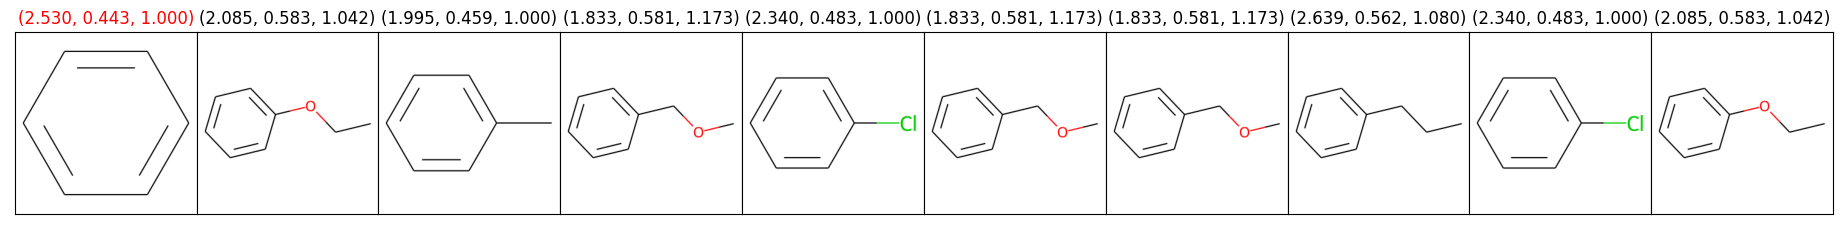

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 11), dpi =100)
fig.subplots_adjust(left=0, right=2, bottom=0, top=2, hspace=0.2, wspace=0)

ax1 = fig.add_subplot(10, 11, 1, xticks=[], yticks=[])
ax1.set_title('({:.3f}, {:.3f}, {:.3f})'.format(target_logp, target_qed, target_SAS), fontsize = 12, color="red")
ax1.imshow(draw_smiles(bz))

for i, smi in enumerate(Moleculars):
    mol = Chem.MolFromSmiles(smi)
    logp = Crippen.MolLogP(mol)
    qed = QED.weights_mean(mol)
    SAS = sascorer.calculateScore(mol)

    ax2 = fig.add_subplot(10, 11, i + 2, xticks=[], yticks=[])
    ax2.set_title('({:.3f}, {:.3f}, {:.3f})'.format(logp, qed, SAS), fontsize = 12)
    ax2.imshow(draw_smiles(smi))

plt.show()

### Histgram of properties of molecules included in ZINC

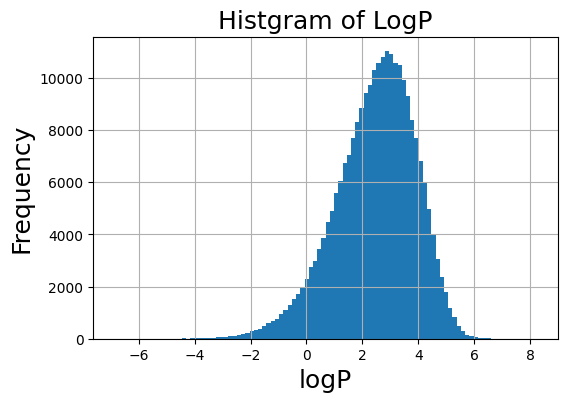

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)

ax.hist(logP, bins=100)
ax.set_title("Histgram of LogP", fontsize=18)
ax.set_xlabel('logP', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.grid(True)

fig.show()

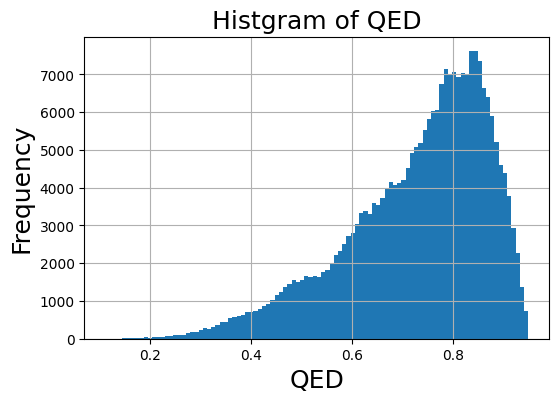

In [ ]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)

ax.hist(qed, bins=100)
ax.set_title("Histgram of QED", fontsize=18)
ax.set_xlabel('QED', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.grid(True)

fig.show()

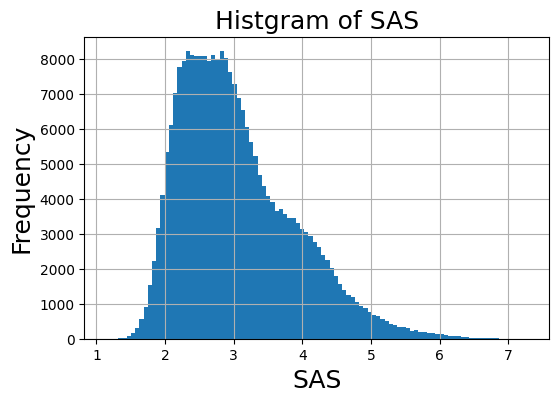

In [ ]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)

ax.hist(SAS, bins=100)
ax.set_title("Histgram of SAS", fontsize=18)
ax.set_xlabel('SAS', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.grid(True)

fig.show()